In [1]:
import numpy as np
import os
import sys

import torch
torch.set_num_threads(os.cpu_count())
from torch import nn

import matplotlib.pyplot as plt
from IPython import display

from pipnet import data
from pipnet import model

np.random.seed(1)

In [57]:
def plot_X(X, y, ws=None, f=None, figsize=(16,6), n_row=2, n_col=3, n_show=4, c0=np.array([0., 1., 1.]), dc=np.array([0., -1., 0.]), file=None):
    
    fig = plt.figure(figsize=figsize)
    axs = []
    for i in range(n_row):
        for j in range(n_col):
            axs.append(fig.add_subplot(n_row, n_col, (i * n_col) + j + 1))

    nw = X.shape[1]
            
    for i in range(n_show):
        if X.dim() == 4:
            if f is None:
                for w in range(nw):
                    axs[i].plot(X[i, w, 0], c=c0+dc*(w/(nw-1)))
            else:
                for w in range(nw):
                    axs[i].plot(f, X[i, w, 0], c=c0+dc*(w/(nw-1)))
        else:
            if f is None:
                axs[i].plot(X[i].T)
            else:
                axs[i].plot(f, X[i].T)
        if y is not None:
            if f is None:
                axs[i].plot(y[i, 0], "k")
            else:
                axs[i].plot(f, y[i, 0], "k")
        
    fig.tight_layout()
    
    if file is not None:
        plt.savefig(file)
    
    plt.show()
    plt.close()
    
    return

In [3]:
def get_param_change(x, w1, w2):
    
    return abs(x / w1 - x / w2), x / w1, x / w2

In [4]:
def get_param_change2(x, w1, w2):
    
    return abs(x / (w1**2) - x / (w2**2)), x / (w1**2), x / (w2**2)

In [5]:
iso_pars = dict(
    td = 512,
    Fs = 12_800,
    nmin = 1,
    nmax = 15,
    freq_range = [2_000., 10_000.],
    gmin = 1,
    gmax = 1,
    spread = 5.,
    lw_range = [[5e1, 2e2], [1e2, 5e2], [1e2, 1e3]],
    lw_probs = [0.7, 0.2, 0.1],
    int_range = [0.5, 1.], # Intensity
    phase = 0.,
    debug = False,
)

mas_pars = dict(
    nw = 8,
    mas_w_range = [30_000., 100_000.],
    random_mas = False,
    mas_phase_p = 0.5,
    mas_phase_scale = 0.05,
    
    # First-order MAS-dependent parameters
    mas1_lw_range = [[1e7, 5e7], [5e7, 1e8]],
    mas1_lw_probs = [0.8, 0.2],
    mas1_m_range = [[0., 0.], [0., 1e4], [1e4, 5e4]],
    mas1_m_probs = [0.1, 0.1, 0.8],
    mas1_s_range = [[-1e7, 1e7]],
    mas1_s_probs = [1.],

    # Second-order MAS-dependent parameters
    mas2_prob = 1.,
    mas2_lw_range = [[0., 0.], [1e11, 5e11]],
    mas2_lw_probs = [0.5, 0.5],
    mas2_m_range = [[0., 0.], [1e8, 5e8]],
    mas2_m_probs = [0.8, 0.2],
    mas2_s_range = [[0., 0.], [-2e10, 2e10]],
    mas2_s_probs = [0.8, 0.2],
    
    # Other MAS-dependent parameters
    non_mas_p = 0.5,
    non_mas_m_trends = ["constant", "increase", "decrease"],
    non_mas_m_probs = [0.34, 0.33, 0.33],
    non_mas_m_range = [0., 1.],
    
    int_decrease_p = 0.1,
    int_decrease_scale =[0.3, 0.7],
    debug = False,
)

data_pars = dict(
    iso_pars = iso_pars,
    mas_pars = mas_pars,
    
    positive_iso = True,
    encode_imag = False, # Encode the imaginary part of the MAS spectra
    encode_wr = True, # Encode the MAS rate of the spectra

    # noise parameters
    noise = 0., # Noise level
    mas_l_noise = 0.05,
    mas_s_noise = 25.,
    
    smooth_end_len = 10, # Smooth ends of spectra
    iso_spec_norm = 256., # Normalization factor for peaks
    mas_spec_norm = 64., # Normalization factor for MAS spectra
    wr_norm_factor = 100_000.,
    wr_inv = False, # Encode inverse of MAS rate instead of MAS rate
    gen_mas_shifts = True,
)

In [6]:
dataset = data.Dataset(**data_pars)
print(dataset.gen_iso.df)

25.0


In [7]:
%%timeit
dataset.__getitem__(0)

10.9 ms ± 549 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [8]:
n_samples = 16
nr = 4
nc = 4

X, y = dataset.generate_batch(size=n_samples)

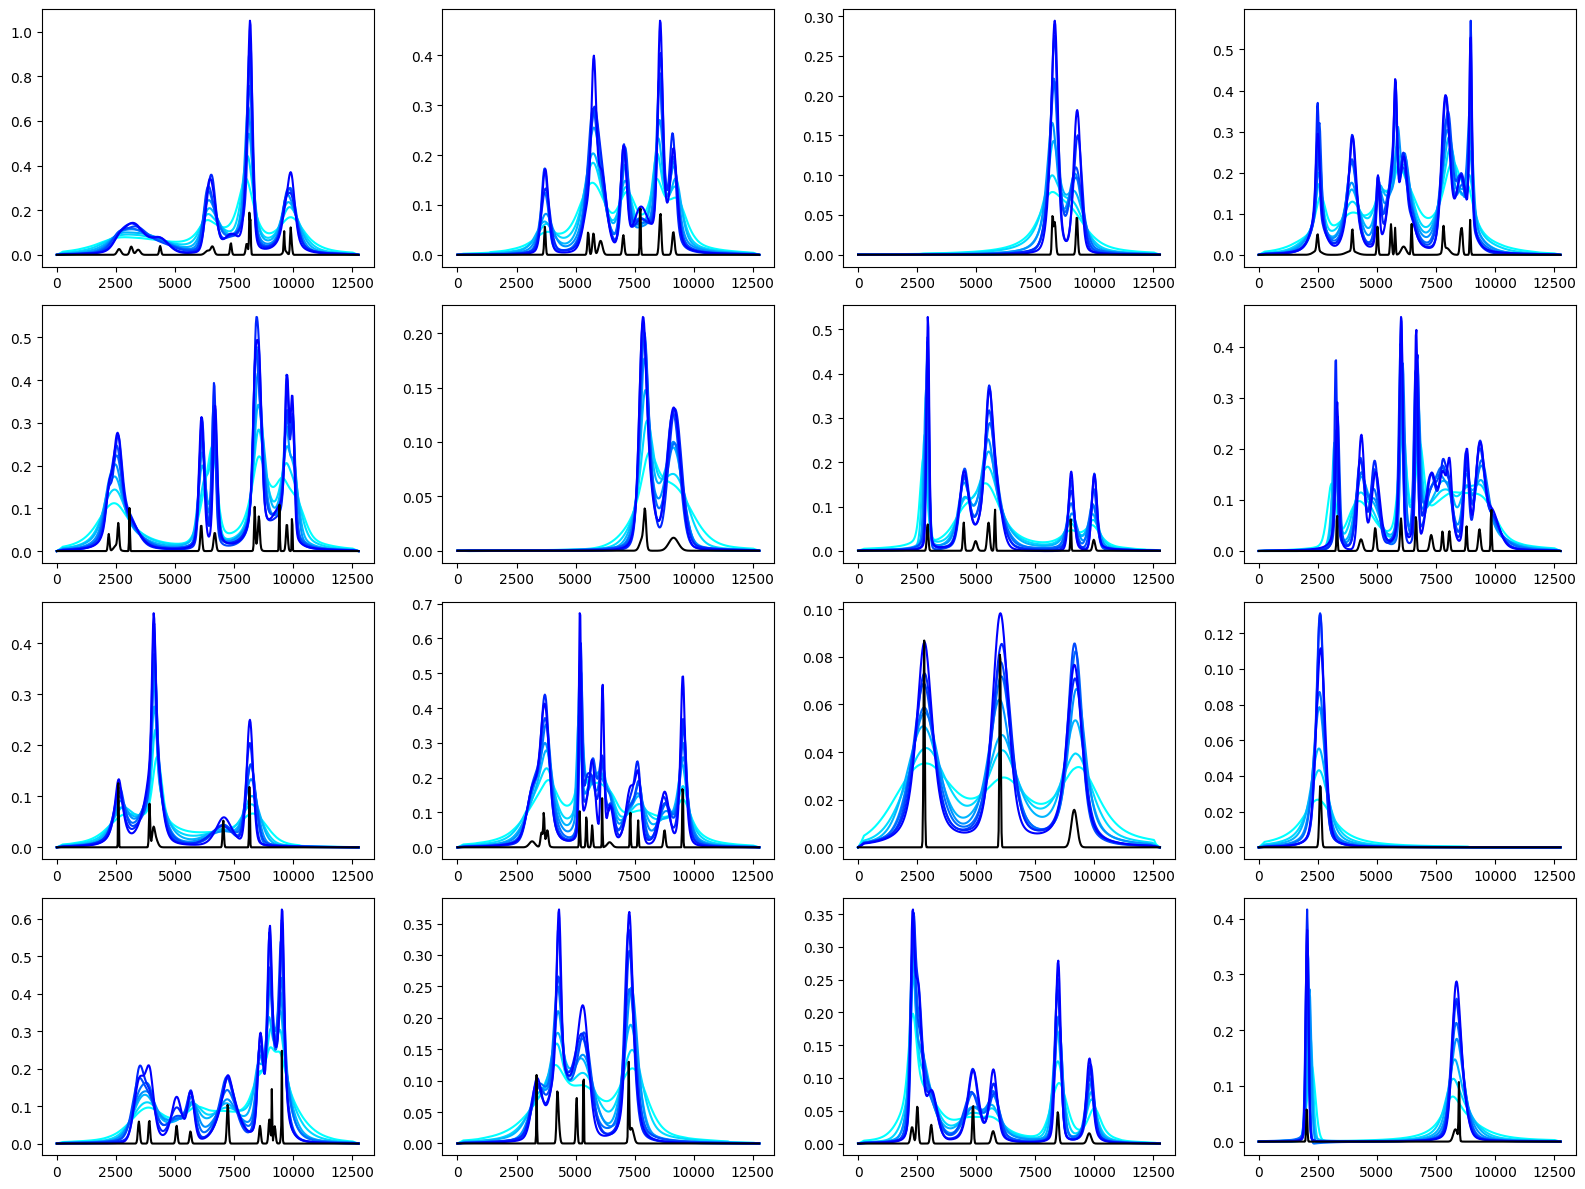

In [59]:
plot_X(X, y / 4., f=dataset.f, figsize=(16, 12), n_row=nr, n_col=nc, n_show=nr*nc, file="data_generation.pdf")